In [1]:
import time
import numpy as np
import pandas as ps
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from harp_beam import compute_EEPs
from functions import to_dBV, stefcal, stefcal_optimised
from plots import plot2

In [2]:
# set random seed
np.random.seed(12042000)

In [3]:
## Q 3. the model matrix, the covariance matrix, the exact gain values and (my) gain estimations are loaded as

filename_vismat = f"data_20feb2024_2330_100MHz.mat"
mat = scipy.io.loadmat(filename_vismat)
R = np.array(mat['R']) # covariance matrix
M_AEP = np.array(mat['M_AEP']) # model matrix using AEP
M_EEPs = np.array(mat['M_EEPs']) # model matrix using all EEPs
g_sol = np.array(mat['g_sol']) # exact gain solution
g_AEP = np.array(mat['g_AEP']) # estimation using M_AEP (using this for question 5 and 6 only if you haven't been able to complete question 3 and 4)
g_EEPs = np.array(mat['g_EEPs']) # estimation using M_EEPs


In [4]:
# StEFCal
M = M_AEP
R = R
max_iteration = 1000
threshold = 1e-9

# Algorithm 1 StEFCal
start = time.time()
G = stefcal(M, R, max_iteration, threshold)
end = time.time()
print(f"Time taken for StEFCal: {end - start} seconds")

# Algorithm 2 StEFCal_optimised
start = time.time()
G_opt = stefcal_optimised(M, R, max_iteration, threshold)
end = time.time()
print(f"Time taken for StEFCal_optimised: {end - start} seconds")

# chek diffferenes in G and G_opt
print(f"Difference between G and G_opt: {np.max(np.abs(G - G_opt))}")

Convergence reached after 633 iterations.
Time taken for StEFCal: 4.640401840209961 seconds
Convergence reached after 633 iterations.
Time taken for StEFCal_optimised: 3.8798019886016846 seconds
Difference between G and G_opt: 0.0


In [10]:
max_iteration = 10000
threshold = 1e-6
g_sol = g_sol

# StEFCal algorithm
def stefcal_optimised(M, R, g_sol, max_iteration=100000, threshold=1e-10):
    # Initial gain matrix G
    G = np.eye(len(M), dtype=complex) # Identity matrix
    abs_error = []

    # Iterative loop
    for i in range(max_iteration):
        # Last iteration of G for comparison
        G_prev = G.copy()
        for p in range(G.shape[0]):  # Loop over antennas p
            z = np.dot(G_prev, M[:,p])  # Use all rows of M_AEP for antenna p
            gp = np.dot(np.conjugate(R[:,p]).T, z) / np.dot(np.conjugate(z).T, z)  # Calculate new gain for antenna p
            G[p, p] = gp  # Update the gain for antenna p in the matrix

        # absolute error between g_sol
        G_diagonal = G.diagonal().reshape(-1, 1)
        error = np.abs(G_diagonal - g_sol)
        abs_error.append(np.mean(error))  

        # Convergence check even iterations
        if i % 2 == 0:
            delta_G = np.linalg.norm(G - G_prev, 'fro') / np.linalg.norm(G, 'fro')
            if delta_G < threshold:
                print(f"Convergence reached after {i+1} iterations.")
                break
            else:
                G = (G + G_prev) / 2

    return G, abs_error

G_aep, abs_error_Maep = stefcal_optimised(M = M_AEP, R = R, g_sol = g_sol, max_iteration = max_iteration, threshold=threshold)
G_eep, abs_error_Meep = stefcal_optimised(M = M_EEPs, R = R, g_sol = g_sol, max_iteration = max_iteration, threshold=threshold)

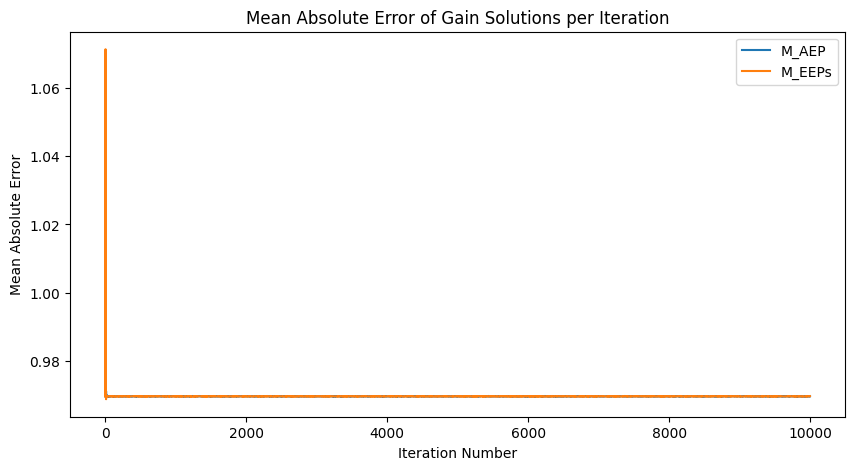

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(abs_error_Maep, label='M_AEP')
plt.plot(abs_error_Meep, label='M_EEPs')
plt.xlabel('Iteration Number')
#plt.xlim(0, 1000)
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error of Gain Solutions per Iteration')
plt.legend()
plt.show()

In [12]:
## Q 3. the model matrix, the covariance matrix, the exact gain values and (my) gain estimations are loaded as

filename_vismat = f"data_20feb2024_2330_100MHz.mat"
mat = scipy.io.loadmat(filename_vismat)
R = np.array(mat['R']) # covariance matrix
M_AEP = np.array(mat['M_AEP']) # model matrix using AEP
M_EEPs = np.array(mat['M_EEPs']) # model matrix using all EEPs
g_sol = np.array(mat['g_sol']) # exact gain solution
g_AEP = np.array(mat['g_AEP']) # estimation using M_AEP (using this for question 5 and 6 only if you haven't been able to complete question 3 and 4)
g_EEPs = np.array(mat['g_EEPs']) # estimation using M_EEPs

In [13]:
import numpy as np

# Initialize variables
imax = 100  # maximum number of iterations, this can be adjusted as needed
tau = 1e-6  # convergence threshold, this can be adjusted as needed
n = 256  # size of the matrix

# Initialize matrices with random complex numbers for the example
# In practice, these should be provided as inputs
R = np.random.randn(n, n) + 1j * np.random.randn(n, n)
M = np.random.randn(n, n) + 1j * np.random.randn(n, n)

# Initialize G[0] as an identity matrix
G = [np.eye(n, dtype=np.complex128)]

# Algorithm implementation
for i in range(1, imax + 1):
    G.append(np.copy(G[i - 1]))  # Start with the previous estimate
    for p in range(n):
        Z = G[i - 1] @ M[:, p]  # Element-wise multiplication in the context is a matrix-vector multiplication
        gp = np.conj(R[:, p]) @ Z / (np.conj(Z).T @ Z)  # Update rule for g_p
        # Update G[i] for each p
        G[i][:, p] = gp * G[i - 1][:, p]
    
    # Convergence check every second iteration
    if i % 2 == 0:
        norm_diff = np.linalg.norm(G[i] - G[i - 1], 'fro')
        norm_G = np.linalg.norm(G[i], 'fro')
        if norm_diff / norm_G <= tau:
            print("Convergence reached at iteration", i)
            break  # Convergence reached, exit the loop
        else:
            # Average the last two estimates
            G[i] = (G[i] + G[i - 1]) / 2

# Result
G_converged = G[-1]
G_converged.shape  # Output the shape to verify the final matrix shape

(256, 256)

numsamples: 1.0
(256, 256)
Norms: [0.9999999924307509, 1.0000000689069974, 0.999999918428955, 0.9999996517265898, 1.000003476411553, 1.0000386577685834, 1.0000192248431272, 1.0003053685286893, 1.0006885276992816, 1.010107964050429, 1.0500257567884412, 1.3951602499965243, 0.8563218257414238, 0.6731044139815794, 0.5732573346063793, 0.5564113705934882, 0.5635531686887426, 0.5283431779038353, 0.48801190012043805, 0.45919879941909775, 0.4603652186720951, 0.4652050835812366, 0.4510671690172661, 0.44284401019153435, 0.4525313138574193, 0.4922703234457156, 0.4495250066867674, 0.43134734481878273, 0.42232474342225135, 0.4204462990930014, 0.4262895918658054, 0.4351513931002627, 0.45892170435239105, 0.47629241559218805, 0.49049640140566925, 0.499310429954705, 0.48360937667141246, 0.4755009270096357, 0.49175772155405056, 0.47781341743761846, 0.46767157913951163, 0.44215470460018097, 0.4676831420508029, 0.47241782340705674, 0.4784119688723708, 0.47242373899886153, 0.46701021734169496, 0.47134513948

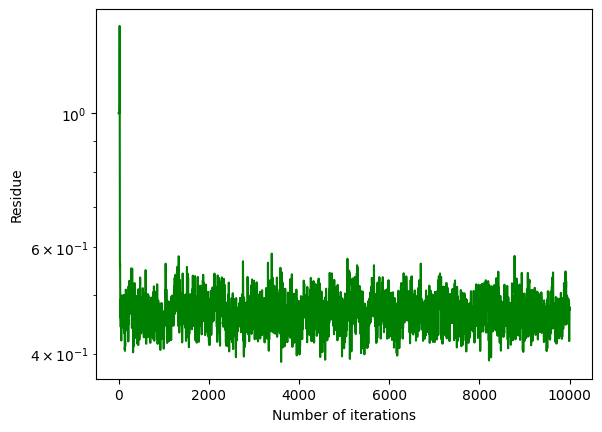

In [14]:
from __future__ import division
import numpy as np
import scipy.io as sc
import scipy.linalg as lin
import sys
from matplotlib import pyplot

def stefcalnondir(M, R, tau=0.000001, imax=10000):
    nst = len(R)
    numsamples = M.shape[0] / M.shape[1]
    print("numsamples:", numsamples)

    # Initiate g[0]
    gs = []
    gs += [np.ones(nst, dtype=complex)]

    # Modify R to be in the same form as M:
    R = np.tile(R, (numsamples, 1))
    print(R.shape)

    norms = []

    for i in range(1, imax):
        g = np.zeros(nst, dtype=complex)

        for p in range(0, nst):
            Zp = np.tile(gs[i-1], numsamples) * M[:, p]
            g[p] = (R[:, p].conjugate().dot(Zp)).item() / lin.norm(Zp)**2

        gs += [g]
        if np.mod(i, 2) == 0 and i > 0:
            norm = lin.norm(gs[i] - gs[i-1]) / lin.norm(gs[i])
            norms += [norm]

            if norm >= tau or norm <= -tau:
                gs[i] = (gs[i] + gs[i-1]) / 2
            else:
                break

    print("Norms:", norms)
    print("Number of iterations:", i)

    I = np.arange(2, i+1, 2)
    pyplot.plot(I, norms, color='green')
    pyplot.yscale('log')
    pyplot.ylabel('Residue')
    pyplot.xlabel('Number of iterations')
    pyplot.show()

    return gs

gs = stefcalnondir(M_AEP, R)

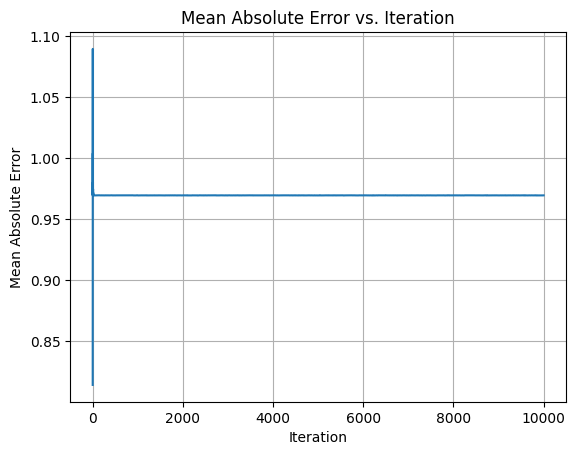

In [15]:
# Calculate the absolute error at each iteration
errors = np.abs(gs - g_sol.T)  # Use g_sol.T to match the shapes, gs (1000, 256) and g_sol.T (1, 256)

# Sum or average the errors across all 256 elements to get a single error value per iteration
# Here, we use the mean, but you could also use the sum or another metric
mean_errors = np.mean(errors, axis=1)

# Plot the error against iteration
plt.plot(mean_errors)
plt.xlabel('Iteration')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error vs. Iteration')
plt.grid(True)
plt.show()